In [1]:
from pathlib import Path
from tqdm import trange

import torch
import torch.nn.functional as F

import taichi as ti

from differender.volume_raycaster import Raycaster, Mode
from differender.utils import get_rand_pos, in_circles, get_tf

from torchvtk.datasets import TorchDataset
from torchvtk.utils import TFGenerator, tex_from_pts, make_4d
from torchvtk.rendering import show_tf, plot_tf, plot_comp_render_tf

import matplotlib.pyplot as plt

[Taichi] version 0.8.5, llvm 10.0.0, commit 45c6ad48, linux, python 3.7.11
[I 03/27/22 07:43:51.576 886] [shell.py:_shell_pop_print@34] Graphical python shell detected, using wrapped sys.stdout
[TaiGLSL] version 0.0.11


In [2]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'wysiwyp'],
                                        ['depth1', 'depth2', 'depth3'],
                                        ['alpha1', 'alpha2', 'alpha3'],
                                        ['sorted1','sorted2','sorted3'],
                                        ['diff1','diff2','diff3']], figsize=(15,25))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['rgb'].set_axis_off()
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['alpha'].set_axis_off()
    axs['wysiwyp'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    axs['wysiwyp'].set_axis_off()    
    
    axs['depth1'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['depth1'].set_title('Interval 1')
    axs['depth1'].set_axis_off()
    axs['depth2'].imshow(im.squeeze()[[5]].permute(1,2,0).cpu().numpy())
    axs['depth2'].set_title('Interval 2')
    axs['depth2'].set_axis_off()
    axs['depth3'].imshow(im.squeeze()[[6]].permute(1,2,0).cpu().numpy())
    axs['depth3'].set_title('Interval 3')
    axs['depth3'].set_axis_off()
    axs['alpha1'].imshow(im.squeeze()[[7]].permute(1,2,0).cpu().numpy())
    axs['alpha1'].set_title('Alpha at I1')
    axs['alpha1'].set_axis_off()
    axs['alpha2'].imshow(im.squeeze()[[8]].permute(1,2,0).cpu().numpy())
    axs['alpha2'].set_title('Alpha at I2')
    axs['alpha2'].set_axis_off()
    axs['alpha3'].imshow(im.squeeze()[[9]].permute(1,2,0).cpu().numpy())
    axs['alpha3'].set_title('Alpha at I3')
    axs['alpha3'].set_axis_off()

    
    sorted_depth, idx = rgbad[4:7].sort(dim=0)
    axs['sorted1'].imshow(sorted_depth[[0]].permute(1,2,0).cpu().numpy())
    axs['sorted1'].set_title('Sorted Depth 1')
    axs['sorted1'].set_axis_off()
    axs['sorted2'].imshow(sorted_depth[[1]].permute(1,2,0).cpu().numpy())
    axs['sorted2'].set_title('Sorted Depth 2')
    axs['sorted2'].set_axis_off()
    axs['sorted3'].imshow(sorted_depth[[2]].permute(1,2,0).cpu().numpy())
    axs['sorted3'].set_title('Sorted Depth 3')
    axs['sorted3'].set_axis_off()
    
    if 'diff1' in axs:
        diff1 = sorted_depth[1] - sorted_depth[0]
        diff2 = sorted_depth[2] - sorted_depth[1]
        diff3 = sorted_depth[2] - sorted_depth[0]
        axs['diff1'].imshow(diff1[None].permute(1,2,0).cpu().numpy())
        axs['diff1'].set_title('Sorted 2 - 1')
        axs['diff1'].set_axis_off()
        axs['diff2'].imshow(diff2[None].permute(1,2,0).cpu().numpy())
        axs['diff2'].set_title('Sorted 3 - 2')
        axs['diff2'].set_axis_off()
        axs['diff3'].imshow(diff3[None].permute(1,2,0).cpu().numpy())
        axs['diff3'].set_title('Sorted 3 - 1')
        axs['diff3'].set_axis_off()
    
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        fig.title(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

In [3]:
def show_all_ims(render):
    fig, ax = plt.subplot_mosaic([['full_rgb', 'full_a', 'full_d'],
                                  ['l1_rgb', 'l1_a', 'l1_d'],
                                  ['l2_rgb', 'l2_a', 'l2_d'],
                                  ['l3_rgb', 'l3_a', 'l3_d'],
                                 ], figsize=(15,20))
    ax['full_rgb'].imshow(render[:3].permute(1,2,0))
    ax['full_rgb'].set_title('Full RGB')
    ax['full_rgb'].set_axis_off()
    ax['full_a'].imshow(render[[3]].permute(1,2,0))
    ax['full_a'].set_title('Full Alpha')
    ax['full_a'].set_axis_off()
    ax['full_d'].imshow(render[[4]].permute(1,2,0))
    ax['full_d'].set_title('Full Depth')
    ax['full_d'].set_axis_off()
    
    ax['l1_rgb'].imshow(render[7:10].permute(1,2,0))
    ax['l1_rgb'].set_title('Layer 1 RGB')
    ax['l1_rgb'].set_axis_off()
    ax['l1_a'].imshow(render[[10]].permute(1,2,0))
    ax['l1_a'].set_title('Layer 1 Alpha')
    ax['l1_a'].set_axis_off()
    ax['l1_d'].imshow(render[[4]].permute(1,2,0))
    ax['l1_d'].set_title('Layer 1 Depth')
    ax['l1_d'].set_axis_off()
    
    ax['l2_rgb'].imshow(render[11:14].permute(1,2,0))
    ax['l2_rgb'].set_title('Layer 2 RGB')
    ax['l2_rgb'].set_axis_off()
    ax['l2_a'].imshow(render[[14]].permute(1,2,0))
    ax['l2_a'].set_title('Layer 2 Alpha')
    ax['l2_a'].set_axis_off()
    ax['l2_d'].imshow(render[[5]].permute(1,2,0))
    ax['l2_d'].set_title('Layer 2 Depth')
    ax['l2_d'].set_axis_off()
    
    ax['l3_rgb'].imshow(render[15:18].permute(1,2,0))
    ax['l3_rgb'].set_title('Layer 3 RGB')
    ax['l3_rgb'].set_axis_off()
    ax['l3_a'].imshow(render[[18]].permute(1,2,0))
    ax['l3_a'].set_title('Layer 3 Alpha')
    ax['l3_a'].set_axis_off()
    ax['l3_d'].imshow(render[[6]].permute(1,2,0))
    ax['l3_d'].set_title('Layer 3 Depth')
    ax['l3_d'].set_axis_off()

In [4]:
N_ITEMS = 100000
W, H = 512, 512
TF_RES = 256
BINS = 51
SR = 16.0 # Sampling rate
MODE = Mode.WYSIWYP

out_dir = Path('/mnt/hdd/dome/STDepth_data_multi_wys2')

ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
# ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
N_VOLUMES = len(ds)

In [5]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': (2,3),
    'height_range': (0.02, 0.4),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

In [6]:
raycaster = None
skips = 0
visibilities = []
for v in trange(125, N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, mode=MODE,
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, ti_kwargs={'device_memory_fraction':0.5})
    for i in trange(N_ITEMS // N_VOLUMES):
        fn = out_dir/f'{nam}_{i}.pt'
        if fn.exists(): continue
        while True:
            lf = get_rand_pos(1).float().to('cuda')
            tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
            rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, layer_dist_thresh=2e-2).squeeze(0)
            hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0)
            vis = hst[1:-1].sum()/rgbad[3].numel() # Visibility as in % of pixels with 0.02 < a < 0.9
            if (rgbad[3] > 0.0).float().mean() < 0.1:
                skips += 1
                #print(f'Skipping another useless render ({skips})')
                continue
            elif vis < 0.2:
                skips += 1
                #print(f'Skipping another too transparent render ({skips})')
                continue
            else:
                visibilities.append(vis.cpu().float())
                full = torch.clamp(rgbad[:4], 0.0, 1.0)
                layer1 = torch.cat([rgbad[7:11],  rgbad[[4]]], dim=0)
                layer2 = torch.cat([rgbad[11:15], rgbad[[5]]], dim=0)
                layer3 = torch.cat([rgbad[15:19], rgbad[[6]]], dim=0)

                back = (full - layer1[:4]) / (1.0 - layer1[3])
                back[:3] = torch.nan_to_num(back[:3] / back[3])
                back = torch.clamp(back, 0.0, 1.0)
                
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': full.cpu().half(),
                    'back': back.cpu().half(),
                    'layer1': layer1.cpu().half(),
                    'layer2': layer2.cpu().half(),
                    'layer3': layer3.cpu().half(),
                    'visibility': vis.cpu().float()
                }, fn)
                break
print(f'Average visibility in the dataset: {torch.stack(visibilities).mean():.1%}')

  0%|          | 0/270 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



  0%|          | 1/270 [00:11<49:45, 11.10s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/270 [00:28<1:06:42, 14.93s/it]

[Taichi] Starting on arch=cuda



  1%|          | 3/270 [00:46<1:12:07, 16.21s/it]

[Taichi] Starting on arch=cuda



  1%|▏         | 4/270 [00:57<1:03:35, 14.35s/it]

[Taichi] Starting on arch=cuda



  2%|▏         | 5/270 [01:07<55:29, 12.56s/it]  

[Taichi] Starting on arch=cuda



  2%|▏         | 6/270 [01:17<51:35, 11.73s/it]

[Taichi] Starting on arch=cuda



  3%|▎         | 7/270 [01:26<47:39, 10.87s/it]

[Taichi] Starting on arch=cuda



  3%|▎         | 8/270 [01:35<44:32, 10.20s/it]

[Taichi] Starting on arch=cuda



  3%|▎         | 9/270 [01:46<45:04, 10.36s/it]

[Taichi] Starting on arch=cuda



  4%|▎         | 10/270 [01:53<41:13,  9.51s/it]

[Taichi] Starting on arch=cuda



  4%|▍         | 11/270 [02:03<41:15,  9.56s/it]

[Taichi] Starting on arch=cuda



  4%|▍         | 12/270 [02:12<40:09,  9.34s/it]

[Taichi] Starting on arch=cuda



  5%|▍         | 13/270 [02:21<40:26,  9.44s/it]

[Taichi] Starting on arch=cuda



  5%|▌         | 14/270 [02:30<39:13,  9.19s/it]

[Taichi] Starting on arch=cuda



  6%|▌         | 15/270 [02:38<37:31,  8.83s/it]

[Taichi] Starting on arch=cuda



  6%|▌         | 16/270 [02:47<37:20,  8.82s/it]

[Taichi] Starting on arch=cuda



  6%|▋         | 17/270 [02:55<36:13,  8.59s/it]

[Taichi] Starting on arch=cuda



  7%|▋         | 18/270 [03:06<39:10,  9.33s/it]

[Taichi] Starting on arch=cuda



  7%|▋         | 19/270 [03:17<40:48,  9.75s/it]

[Taichi] Starting on arch=cuda



  7%|▋         | 20/270 [03:26<40:50,  9.80s/it]

[Taichi] Starting on arch=cuda



  8%|▊         | 21/270 [03:34<37:39,  9.08s/it]

[Taichi] Starting on arch=cuda



  8%|▊         | 22/270 [03:41<34:35,  8.37s/it]

[Taichi] Starting on arch=cuda



  9%|▊         | 23/270 [03:48<33:26,  8.12s/it]

[Taichi] Starting on arch=cuda



  9%|▉         | 24/270 [03:58<35:09,  8.58s/it]

[Taichi] Starting on arch=cuda



  9%|▉         | 25/270 [04:08<36:40,  8.98s/it]

[Taichi] Starting on arch=cuda



 10%|▉         | 26/270 [04:17<36:34,  8.99s/it]

[Taichi] Starting on arch=cuda



 10%|█         | 27/270 [04:23<33:25,  8.25s/it]

[Taichi] Starting on arch=cuda



 10%|█         | 28/270 [04:33<34:43,  8.61s/it]

[Taichi] Starting on arch=cuda



 11%|█         | 29/270 [04:40<33:18,  8.29s/it]

[Taichi] Starting on arch=cuda



 11%|█         | 30/270 [04:44<27:30,  6.88s/it]

[Taichi] Starting on arch=cuda



 11%|█▏        | 31/270 [04:52<28:27,  7.14s/it]

[Taichi] Starting on arch=cuda



 12%|█▏        | 32/270 [05:02<32:16,  8.14s/it]

[Taichi] Starting on arch=cuda



 12%|█▏        | 33/270 [05:09<31:07,  7.88s/it]

[Taichi] Starting on arch=cuda



 13%|█▎        | 34/270 [05:15<28:06,  7.15s/it]

[Taichi] Starting on arch=cuda



 13%|█▎        | 35/270 [05:25<31:45,  8.11s/it]

[Taichi] Starting on arch=cuda



 13%|█▎        | 36/270 [05:34<31:59,  8.20s/it]

[Taichi] Starting on arch=cuda



 14%|█▎        | 37/270 [05:41<31:29,  8.11s/it]

[Taichi] Starting on arch=cuda



 14%|█▍        | 38/270 [05:50<31:29,  8.15s/it]

[Taichi] Starting on arch=cuda



 14%|█▍        | 39/270 [05:57<30:37,  7.95s/it]

[Taichi] Starting on arch=cuda



 15%|█▍        | 40/270 [06:11<37:21,  9.75s/it]

[Taichi] Starting on arch=cuda



 15%|█▌        | 41/270 [06:21<37:32,  9.83s/it]

[Taichi] Starting on arch=cuda



 16%|█▌        | 42/270 [06:29<34:39,  9.12s/it]

[Taichi] Starting on arch=cuda



 16%|█▌        | 43/270 [06:38<34:36,  9.15s/it]

[Taichi] Starting on arch=cuda



 16%|█▋        | 44/270 [06:48<35:53,  9.53s/it]

[Taichi] Starting on arch=cuda



 17%|█▋        | 45/270 [07:00<38:23, 10.24s/it]

[Taichi] Starting on arch=cuda



 17%|█▋        | 46/270 [07:09<36:55,  9.89s/it]

[Taichi] Starting on arch=cuda



 17%|█▋        | 47/270 [07:18<36:02,  9.70s/it]

[Taichi] Starting on arch=cuda



 18%|█▊        | 48/270 [07:27<35:11,  9.51s/it]

[Taichi] Starting on arch=cuda



 18%|█▊        | 49/270 [07:31<28:31,  7.74s/it]

[Taichi] Starting on arch=cuda



 19%|█▊        | 50/270 [07:41<30:40,  8.37s/it]

[Taichi] Starting on arch=cuda



 19%|█▉        | 51/270 [07:53<34:58,  9.58s/it]

[Taichi] Starting on arch=cuda



 19%|█▉        | 52/270 [08:01<33:13,  9.15s/it]

[Taichi] Starting on arch=cuda



 20%|█▉        | 53/270 [08:10<32:33,  9.00s/it]

[Taichi] Starting on arch=cuda



 20%|██        | 54/270 [08:18<31:26,  8.73s/it]

[Taichi] Starting on arch=cuda



 20%|██        | 55/270 [08:29<33:11,  9.26s/it]

[Taichi] Starting on arch=cuda



 21%|██        | 56/270 [08:43<38:29, 10.79s/it]

[Taichi] Starting on arch=cuda



 21%|██        | 57/270 [08:53<37:17, 10.51s/it]

[Taichi] Starting on arch=cuda



 21%|██▏       | 58/270 [09:01<34:45,  9.84s/it]

[Taichi] Starting on arch=cuda



 22%|██▏       | 59/270 [09:09<32:04,  9.12s/it]

[Taichi] Starting on arch=cuda



 22%|██▏       | 60/270 [09:19<33:01,  9.44s/it]

[Taichi] Starting on arch=cuda



 23%|██▎       | 61/270 [09:26<30:57,  8.89s/it]

[Taichi] Starting on arch=cuda



 23%|██▎       | 62/270 [09:35<30:50,  8.90s/it]

[Taichi] Starting on arch=cuda



 23%|██▎       | 63/270 [09:51<37:57, 11.00s/it]

[Taichi] Starting on arch=cuda



 24%|██▎       | 64/270 [10:04<39:21, 11.46s/it]

[Taichi] Starting on arch=cuda



 24%|██▍       | 65/270 [10:12<35:50, 10.49s/it]

[Taichi] Starting on arch=cuda



 24%|██▍       | 66/270 [10:20<32:37,  9.59s/it]

[Taichi] Starting on arch=cuda



 25%|██▍       | 67/270 [10:30<32:59,  9.75s/it]

[Taichi] Starting on arch=cuda



 25%|██▌       | 68/270 [10:37<30:45,  9.13s/it]

[Taichi] Starting on arch=cuda



 26%|██▌       | 69/270 [10:43<27:22,  8.17s/it]

[Taichi] Starting on arch=cuda



 26%|██▌       | 70/270 [10:54<29:36,  8.88s/it]

[Taichi] Starting on arch=cuda



 26%|██▋       | 71/270 [11:02<29:05,  8.77s/it]

[Taichi] Starting on arch=cuda



 27%|██▋       | 72/270 [11:08<26:21,  7.99s/it]

[Taichi] Starting on arch=cuda



 27%|██▋       | 73/270 [11:17<27:08,  8.27s/it]

[Taichi] Starting on arch=cuda



 27%|██▋       | 74/270 [11:23<23:55,  7.32s/it]

[Taichi] Starting on arch=cuda



 28%|██▊       | 75/270 [11:30<24:08,  7.43s/it]

[Taichi] Starting on arch=cuda



 28%|██▊       | 76/270 [11:43<29:29,  9.12s/it]

[Taichi] Starting on arch=cuda



 29%|██▊       | 77/270 [11:55<31:53,  9.92s/it]

[Taichi] Starting on arch=cuda



 29%|██▉       | 78/270 [12:05<31:44,  9.92s/it]

[Taichi] Starting on arch=cuda



 29%|██▉       | 79/270 [12:13<29:49,  9.37s/it]

[Taichi] Starting on arch=cuda



 30%|██▉       | 80/270 [12:20<27:22,  8.64s/it]

[Taichi] Starting on arch=cuda



 30%|███       | 81/270 [12:32<30:01,  9.53s/it]

[Taichi] Starting on arch=cuda



 30%|███       | 82/270 [12:40<28:34,  9.12s/it]

[Taichi] Starting on arch=cuda



 31%|███       | 83/270 [12:45<25:11,  8.08s/it]

[Taichi] Starting on arch=cuda



 31%|███       | 84/270 [12:52<23:41,  7.64s/it]

[Taichi] Starting on arch=cuda



 31%|███▏      | 85/270 [12:57<20:41,  6.71s/it]

[Taichi] Starting on arch=cuda



 32%|███▏      | 86/270 [13:05<22:14,  7.25s/it]

[Taichi] Starting on arch=cuda



 32%|███▏      | 87/270 [13:12<21:22,  7.01s/it]

[Taichi] Starting on arch=cuda



 33%|███▎      | 88/270 [13:18<20:49,  6.87s/it]

[Taichi] Starting on arch=cuda



 33%|███▎      | 89/270 [13:25<20:39,  6.85s/it]

[Taichi] Starting on arch=cuda



 33%|███▎      | 90/270 [13:30<18:58,  6.32s/it]

[Taichi] Starting on arch=cuda



 34%|███▎      | 91/270 [13:38<20:38,  6.92s/it]

[Taichi] Starting on arch=cuda



 34%|███▍      | 92/270 [13:46<20:53,  7.04s/it]

[Taichi] Starting on arch=cuda



 34%|███▍      | 93/270 [13:54<21:42,  7.36s/it]

[Taichi] Starting on arch=cuda



 35%|███▍      | 94/270 [14:01<21:18,  7.26s/it]

[Taichi] Starting on arch=cuda



 35%|███▌      | 95/270 [14:09<21:53,  7.50s/it]

[Taichi] Starting on arch=cuda



 36%|███▌      | 96/270 [14:17<22:16,  7.68s/it]

[Taichi] Starting on arch=cuda



 36%|███▌      | 97/270 [14:27<24:26,  8.48s/it]

[Taichi] Starting on arch=cuda



 36%|███▋      | 98/270 [14:35<23:39,  8.26s/it]

[Taichi] Starting on arch=cuda



 37%|███▋      | 99/270 [14:43<23:03,  8.09s/it]

[Taichi] Starting on arch=cuda



 37%|███▋      | 100/270 [14:51<23:15,  8.21s/it]

[Taichi] Starting on arch=cuda



 37%|███▋      | 101/270 [14:59<23:03,  8.19s/it]

[Taichi] Starting on arch=cuda



 38%|███▊      | 102/270 [15:05<20:54,  7.47s/it]

[Taichi] Starting on arch=cuda



 38%|███▊      | 103/270 [15:15<22:46,  8.19s/it]

[Taichi] Starting on arch=cuda



 39%|███▊      | 104/270 [15:24<23:05,  8.35s/it]

[Taichi] Starting on arch=cuda



 39%|███▉      | 105/270 [15:29<20:28,  7.44s/it]

[Taichi] Starting on arch=cuda



 39%|███▉      | 106/270 [15:38<21:11,  7.76s/it]

[Taichi] Starting on arch=cuda



 40%|███▉      | 107/270 [15:45<20:49,  7.67s/it]

[Taichi] Starting on arch=cuda



 40%|████      | 108/270 [15:50<18:41,  6.92s/it]

[Taichi] Starting on arch=cuda



 40%|████      | 109/270 [15:56<17:42,  6.60s/it]

[Taichi] Starting on arch=cuda



 41%|████      | 110/270 [16:02<17:02,  6.39s/it]

[Taichi] Starting on arch=cuda



 41%|████      | 111/270 [16:10<18:10,  6.86s/it]

[Taichi] Starting on arch=cuda



 41%|████▏     | 112/270 [16:16<17:26,  6.62s/it]

[Taichi] Starting on arch=cuda



 42%|████▏     | 113/270 [16:22<16:53,  6.46s/it]

[Taichi] Starting on arch=cuda



 42%|████▏     | 114/270 [16:29<16:54,  6.50s/it]

[Taichi] Starting on arch=cuda



 43%|████▎     | 115/270 [16:34<16:18,  6.32s/it]

[Taichi] Starting on arch=cuda



 43%|████▎     | 116/270 [16:42<16:53,  6.58s/it]

[Taichi] Starting on arch=cuda



 43%|████▎     | 117/270 [16:48<16:55,  6.64s/it]

[Taichi] Starting on arch=cuda



 44%|████▎     | 118/270 [16:55<16:44,  6.61s/it]

[Taichi] Starting on arch=cuda



 44%|████▍     | 119/270 [17:01<16:10,  6.43s/it]

[Taichi] Starting on arch=cuda



 44%|████▍     | 120/270 [17:14<20:46,  8.31s/it]

[Taichi] Starting on arch=cuda



 45%|████▍     | 121/270 [17:22<20:47,  8.37s/it]

[Taichi] Starting on arch=cuda



 45%|████▌     | 122/270 [17:28<18:49,  7.63s/it]

[Taichi] Starting on arch=cuda



 46%|████▌     | 123/270 [17:35<17:54,  7.31s/it]

[Taichi] Starting on arch=cuda



 46%|████▌     | 124/270 [17:41<16:51,  6.93s/it]

[Taichi] Starting on arch=cuda



 46%|████▋     | 125/270 [17:47<16:25,  6.80s/it]

[Taichi] Starting on arch=cuda



 47%|████▋     | 126/270 [17:56<17:32,  7.31s/it]

[Taichi] Starting on arch=cuda



 47%|████▋     | 127/270 [18:04<18:15,  7.66s/it]

[Taichi] Starting on arch=cuda



 47%|████▋     | 128/270 [18:12<18:24,  7.78s/it]

[Taichi] Starting on arch=cuda



 48%|████▊     | 129/270 [18:23<20:04,  8.54s/it]

[Taichi] Starting on arch=cuda



 48%|████▊     | 130/270 [18:32<20:41,  8.87s/it]

[Taichi] Starting on arch=cuda



 49%|████▊     | 131/270 [18:41<20:22,  8.79s/it]

[Taichi] Starting on arch=cuda



 49%|████▉     | 132/270 [18:49<19:46,  8.60s/it]

[Taichi] Starting on arch=cuda



 49%|████▉     | 133/270 [18:57<19:08,  8.38s/it]

[Taichi] Starting on arch=cuda



 50%|████▉     | 134/270 [19:07<19:59,  8.82s/it]

[Taichi] Starting on arch=cuda



 50%|█████     | 135/270 [19:17<20:37,  9.17s/it]

[Taichi] Starting on arch=cuda



 50%|█████     | 136/270 [19:23<18:24,  8.24s/it]

[Taichi] Starting on arch=cuda



 51%|█████     | 137/270 [19:29<16:49,  7.59s/it]

[Taichi] Starting on arch=cuda



 51%|█████     | 138/270 [19:35<16:00,  7.28s/it]

[Taichi] Starting on arch=cuda



 51%|█████▏    | 139/270 [19:41<14:59,  6.86s/it]

[Taichi] Starting on arch=cuda



 52%|█████▏    | 140/270 [19:47<13:56,  6.43s/it]

[Taichi] Starting on arch=cuda



 52%|█████▏    | 141/270 [19:54<14:14,  6.62s/it]

[Taichi] Starting on arch=cuda



 53%|█████▎    | 142/270 [20:01<14:22,  6.74s/it]

[Taichi] Starting on arch=cuda



 53%|█████▎    | 143/270 [20:08<14:47,  6.99s/it]

[Taichi] Starting on arch=cuda



 53%|█████▎    | 144/270 [20:14<13:56,  6.64s/it]

[Taichi] Starting on arch=cuda



 54%|█████▎    | 145/270 [20:21<14:04,  6.75s/it]

[Taichi] Starting on arch=cuda



 54%|█████▍    | 146/270 [20:29<14:42,  7.12s/it]

[Taichi] Starting on arch=cuda



 54%|█████▍    | 147/270 [20:37<14:51,  7.25s/it]

[Taichi] Starting on arch=cuda



 55%|█████▍    | 148/270 [20:44<14:55,  7.34s/it]

[Taichi] Starting on arch=cuda



 55%|█████▌    | 149/270 [20:51<14:32,  7.21s/it]

[Taichi] Starting on arch=cuda



 56%|█████▌    | 150/270 [20:57<13:43,  6.86s/it]

[Taichi] Starting on arch=cuda



 56%|█████▌    | 151/270 [21:04<13:17,  6.70s/it]

[Taichi] Starting on arch=cuda



 56%|█████▋    | 152/270 [21:08<11:47,  6.00s/it]

[Taichi] Starting on arch=cuda



 57%|█████▋    | 153/270 [21:14<11:55,  6.12s/it]

[Taichi] Starting on arch=cuda



 57%|█████▋    | 154/270 [21:18<10:35,  5.48s/it]

[Taichi] Starting on arch=cuda



 57%|█████▋    | 155/270 [21:25<11:03,  5.77s/it]

[Taichi] Starting on arch=cuda



 58%|█████▊    | 156/270 [21:32<11:56,  6.28s/it]

[Taichi] Starting on arch=cuda



 58%|█████▊    | 157/270 [21:37<11:07,  5.91s/it]

[Taichi] Starting on arch=cuda



 59%|█████▊    | 158/270 [21:42<10:38,  5.70s/it]

[Taichi] Starting on arch=cuda



 59%|█████▉    | 159/270 [21:48<10:36,  5.74s/it]

[Taichi] Starting on arch=cuda



 59%|█████▉    | 160/270 [21:54<10:28,  5.71s/it]

[Taichi] Starting on arch=cuda



 60%|█████▉    | 161/270 [21:58<09:18,  5.13s/it]

[Taichi] Starting on arch=cuda



 60%|██████    | 162/270 [22:02<09:02,  5.02s/it]

[Taichi] Starting on arch=cuda



 60%|██████    | 163/270 [22:08<09:00,  5.05s/it]

[Taichi] Starting on arch=cuda



 61%|██████    | 164/270 [22:11<08:11,  4.63s/it]

[Taichi] Starting on arch=cuda



 61%|██████    | 165/270 [22:17<08:44,  4.99s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 166/270 [22:22<08:46,  5.06s/it]

[Taichi] Starting on arch=cuda



 62%|██████▏   | 167/270 [22:28<09:10,  5.34s/it]

[Taichi] Starting on arch=cuda



 62%|██████▏   | 168/270 [22:33<08:42,  5.13s/it]

[Taichi] Starting on arch=cuda



 63%|██████▎   | 169/270 [22:38<08:46,  5.21s/it]

[Taichi] Starting on arch=cuda



 63%|██████▎   | 170/270 [22:43<08:33,  5.13s/it]

[Taichi] Starting on arch=cuda



 63%|██████▎   | 171/270 [22:49<08:41,  5.26s/it]

[Taichi] Starting on arch=cuda



 64%|██████▎   | 172/270 [22:55<09:00,  5.51s/it]

[Taichi] Starting on arch=cuda



 64%|██████▍   | 173/270 [23:00<08:43,  5.39s/it]

[Taichi] Starting on arch=cuda



 64%|██████▍   | 174/270 [23:04<07:56,  4.96s/it]

[Taichi] Starting on arch=cuda



 65%|██████▍   | 175/270 [23:10<08:10,  5.16s/it]

[Taichi] Starting on arch=cuda



 65%|██████▌   | 176/270 [23:14<07:47,  4.97s/it]

[Taichi] Starting on arch=cuda



 66%|██████▌   | 177/270 [23:20<08:07,  5.25s/it]

[Taichi] Starting on arch=cuda



 66%|██████▌   | 178/270 [23:26<08:28,  5.53s/it]

[Taichi] Starting on arch=cuda



 66%|██████▋   | 179/270 [23:32<08:36,  5.67s/it]

[Taichi] Starting on arch=cuda



 67%|██████▋   | 180/270 [23:37<08:00,  5.33s/it]

[Taichi] Starting on arch=cuda



 67%|██████▋   | 181/270 [23:42<07:44,  5.22s/it]

[Taichi] Starting on arch=cuda



 67%|██████▋   | 182/270 [23:46<07:24,  5.05s/it]

[Taichi] Starting on arch=cuda



 68%|██████▊   | 183/270 [23:52<07:31,  5.19s/it]

[Taichi] Starting on arch=cuda



 68%|██████▊   | 184/270 [23:56<07:06,  4.96s/it]

[Taichi] Starting on arch=cuda



 69%|██████▊   | 185/270 [24:03<07:39,  5.40s/it]

[Taichi] Starting on arch=cuda



 69%|██████▉   | 186/270 [24:10<08:19,  5.94s/it]

[Taichi] Starting on arch=cuda



 69%|██████▉   | 187/270 [24:16<08:13,  5.95s/it]

[Taichi] Starting on arch=cuda



 70%|██████▉   | 188/270 [24:19<07:07,  5.22s/it]

[Taichi] Starting on arch=cuda



 70%|███████   | 189/270 [24:24<06:52,  5.09s/it]

[Taichi] Starting on arch=cuda



 70%|███████   | 190/270 [24:30<07:09,  5.36s/it]

[Taichi] Starting on arch=cuda



 71%|███████   | 191/270 [24:35<06:40,  5.07s/it]

[Taichi] Starting on arch=cuda



 71%|███████   | 192/270 [24:40<06:33,  5.05s/it]

[Taichi] Starting on arch=cuda



 71%|███████▏  | 193/270 [24:45<06:28,  5.04s/it]

[Taichi] Starting on arch=cuda



 72%|███████▏  | 194/270 [24:49<06:15,  4.95s/it]

[Taichi] Starting on arch=cuda



 72%|███████▏  | 195/270 [24:54<06:05,  4.87s/it]

[Taichi] Starting on arch=cuda



 73%|███████▎  | 196/270 [25:58<27:51, 22.59s/it]

[Taichi] Starting on arch=cuda



 73%|███████▎  | 197/270 [28:02<1:04:27, 52.97s/it]

[Taichi] Starting on arch=cuda



 73%|███████▎  | 198/270 [30:32<1:38:42, 82.25s/it]

[Taichi] Starting on arch=cuda



 74%|███████▎  | 199/270 [33:31<2:11:26, 111.08s/it]

[Taichi] Starting on arch=cuda



 74%|███████▍  | 200/270 [36:11<2:26:46, 125.81s/it]

[Taichi] Starting on arch=cuda



 74%|███████▍  | 201/270 [38:56<2:38:04, 137.46s/it]

[Taichi] Starting on arch=cuda



 75%|███████▍  | 202/270 [41:50<2:48:23, 148.59s/it]

[Taichi] Starting on arch=cuda



 75%|███████▌  | 203/270 [44:53<2:57:15, 158.74s/it]

[Taichi] Starting on arch=cuda



 76%|███████▌  | 204/270 [48:23<3:11:32, 174.13s/it]

[Taichi] Starting on arch=cuda



 76%|███████▌  | 205/270 [51:41<3:16:31, 181.40s/it]

[Taichi] Starting on arch=cuda



 76%|███████▋  | 206/270 [55:57<3:37:26, 203.85s/it]

[Taichi] Starting on arch=cuda



 77%|███████▋  | 207/270 [59:20<3:33:48, 203.62s/it]

[Taichi] Starting on arch=cuda



 77%|███████▋  | 208/270 [1:03:02<3:36:05, 209.11s/it]

[Taichi] Starting on arch=cuda



 77%|███████▋  | 209/270 [1:06:52<3:39:01, 215.43s/it]

[Taichi] Starting on arch=cuda



 78%|███████▊  | 210/270 [1:10:28<3:35:29, 215.49s/it]

[Taichi] Starting on arch=cuda



 78%|███████▊  | 211/270 [1:14:13<3:34:38, 218.28s/it]

[Taichi] Starting on arch=cuda



 79%|███████▊  | 212/270 [1:17:33<3:25:36, 212.70s/it]

[Taichi] Starting on arch=cuda



 79%|███████▉  | 213/270 [1:20:06<3:05:13, 194.98s/it]

[Taichi] Starting on arch=cuda



 79%|███████▉  | 214/270 [1:22:49<2:53:00, 185.37s/it]

[Taichi] Starting on arch=cuda



 80%|███████▉  | 215/270 [1:25:21<2:40:40, 175.28s/it]

[Taichi] Starting on arch=cuda



 80%|████████  | 216/270 [1:27:54<2:31:44, 168.60s/it]

[Taichi] Starting on arch=cuda



 80%|████████  | 217/270 [1:31:05<2:34:53, 175.35s/it]

[Taichi] Starting on arch=cuda



 81%|████████  | 218/270 [1:33:49<2:29:04, 172.01s/it]

[Taichi] Starting on arch=cuda



 81%|████████  | 219/270 [1:36:30<2:23:25, 168.74s/it]

[Taichi] Starting on arch=cuda



 81%|████████▏ | 220/270 [1:40:11<2:33:33, 184.27s/it]

[Taichi] Starting on arch=cuda



 82%|████████▏ | 221/270 [1:43:02<2:27:17, 180.36s/it]

[Taichi] Starting on arch=cuda



 82%|████████▏ | 222/270 [1:46:33<2:31:40, 189.59s/it]

[Taichi] Starting on arch=cuda



 83%|████████▎ | 223/270 [1:48:46<2:15:07, 172.49s/it]

[Taichi] Starting on arch=cuda



 83%|████████▎ | 224/270 [1:55:40<3:07:49, 244.98s/it]

[Taichi] Starting on arch=cuda



 83%|████████▎ | 225/270 [1:58:09<2:42:10, 216.24s/it]

[Taichi] Starting on arch=cuda



 84%|████████▎ | 226/270 [2:01:36<2:36:35, 213.52s/it]

[Taichi] Starting on arch=cuda



 84%|████████▍ | 227/270 [2:04:26<2:23:38, 200.43s/it]

[Taichi] Starting on arch=cuda



 84%|████████▍ | 228/270 [2:08:48<2:33:15, 218.94s/it]

[Taichi] Starting on arch=cuda



 85%|████████▍ | 229/270 [2:11:23<2:16:30, 199.76s/it]

[Taichi] Starting on arch=cuda



 85%|████████▌ | 230/270 [2:14:15<2:07:32, 191.31s/it]

[Taichi] Starting on arch=cuda



 86%|████████▌ | 231/270 [2:17:18<2:02:43, 188.81s/it]

[Taichi] Starting on arch=cuda



 86%|████████▌ | 232/270 [2:19:25<1:47:54, 170.38s/it]

[Taichi] Starting on arch=cuda



 86%|████████▋ | 233/270 [2:22:04<1:42:56, 166.94s/it]

[Taichi] Starting on arch=cuda



 87%|████████▋ | 234/270 [2:25:02<1:42:06, 170.18s/it]

[Taichi] Starting on arch=cuda



 87%|████████▋ | 235/270 [2:27:36<1:36:32, 165.50s/it]

[Taichi] Starting on arch=cuda



 87%|████████▋ | 236/270 [2:31:00<1:40:18, 177.02s/it]

[Taichi] Starting on arch=cuda



 88%|████████▊ | 237/270 [2:34:30<1:42:40, 186.67s/it]

[Taichi] Starting on arch=cuda



 88%|████████▊ | 238/270 [2:38:01<1:43:27, 193.97s/it]

[Taichi] Starting on arch=cuda



 89%|████████▊ | 239/270 [2:40:23<1:32:13, 178.51s/it]

[Taichi] Starting on arch=cuda



 89%|████████▉ | 240/270 [2:42:58<1:25:40, 171.35s/it]

[Taichi] Starting on arch=cuda



 89%|████████▉ | 241/270 [2:45:48<1:22:41, 171.08s/it]

[Taichi] Starting on arch=cuda



 90%|████████▉ | 242/270 [2:48:25<1:17:49, 166.78s/it]

[Taichi] Starting on arch=cuda



 90%|█████████ | 243/270 [2:51:11<1:14:54, 166.48s/it]

[Taichi] Starting on arch=cuda



 90%|█████████ | 244/270 [2:55:15<1:22:19, 189.99s/it]

[Taichi] Starting on arch=cuda



 91%|█████████ | 245/270 [2:58:22<1:18:40, 188.83s/it]

[Taichi] Starting on arch=cuda



 91%|█████████ | 246/270 [3:01:12<1:13:21, 183.42s/it]

[Taichi] Starting on arch=cuda



 91%|█████████▏| 247/270 [3:03:34<1:05:29, 170.85s/it]

[Taichi] Starting on arch=cuda



 92%|█████████▏| 248/270 [3:06:57<1:06:10, 180.48s/it]

[Taichi] Starting on arch=cuda



 92%|█████████▏| 249/270 [3:10:36<1:07:15, 192.17s/it]

[Taichi] Starting on arch=cuda



 93%|█████████▎| 250/270 [3:12:57<58:55, 176.76s/it]  

[Taichi] Starting on arch=cuda



 93%|█████████▎| 251/270 [3:15:51<55:41, 175.87s/it]

[Taichi] Starting on arch=cuda



 93%|█████████▎| 252/270 [3:18:09<49:23, 164.62s/it]

[Taichi] Starting on arch=cuda



 94%|█████████▎| 253/270 [3:21:43<50:50, 179.44s/it]

[Taichi] Starting on arch=cuda



 94%|█████████▍| 254/270 [3:25:30<51:40, 193.77s/it]

[Taichi] Starting on arch=cuda



 94%|█████████▍| 255/270 [3:27:58<45:00, 180.02s/it]

[Taichi] Starting on arch=cuda



 95%|█████████▍| 256/270 [3:30:48<41:17, 176.96s/it]

[Taichi] Starting on arch=cuda



 95%|█████████▌| 257/270 [3:33:37<37:49, 174.58s/it]

[Taichi] Starting on arch=cuda



 96%|█████████▌| 258/270 [3:36:37<35:13, 176.11s/it]

[Taichi] Starting on arch=cuda



 96%|█████████▌| 259/270 [3:39:34<32:21, 176.52s/it]

[Taichi] Starting on arch=cuda



 96%|█████████▋| 260/270 [3:42:08<28:14, 169.49s/it]

[Taichi] Starting on arch=cuda



 97%|█████████▋| 261/270 [3:45:18<26:23, 175.90s/it]

[Taichi] Starting on arch=cuda



 97%|█████████▋| 262/270 [3:47:49<22:26, 168.35s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [03:43<01:22,  1.19it/s]


 97%|█████████▋| 263/270 [3:54:23<27:32, 236.08s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [03:40<01:19,  1.24it/s]


 98%|█████████▊| 264/270 [4:00:17<27:07, 271.26s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [02:42<01:20,  1.21it/s]


 98%|█████████▊| 265/270 [4:04:44<22:31, 270.24s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [03:04<01:32,  1.06it/s]


 99%|█████████▊| 266/270 [4:09:46<18:38, 279.71s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [02:49<01:12,  1.36it/s]


 99%|█████████▉| 267/270 [4:14:38<14:10, 283.42s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [03:49<04:50,  2.96s/it]


 99%|█████████▉| 268/270 [4:20:50<10:19, 309.88s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [03:46<02:03,  1.26s/it]


100%|█████████▉| 269/270 [4:26:55<05:26, 326.47s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [03:56<02:16,  1.40s/it]


100%|██████████| 270/270 [4:33:31<00:00, 60.78s/it] 

Average visibility in the dataset: 29.8%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


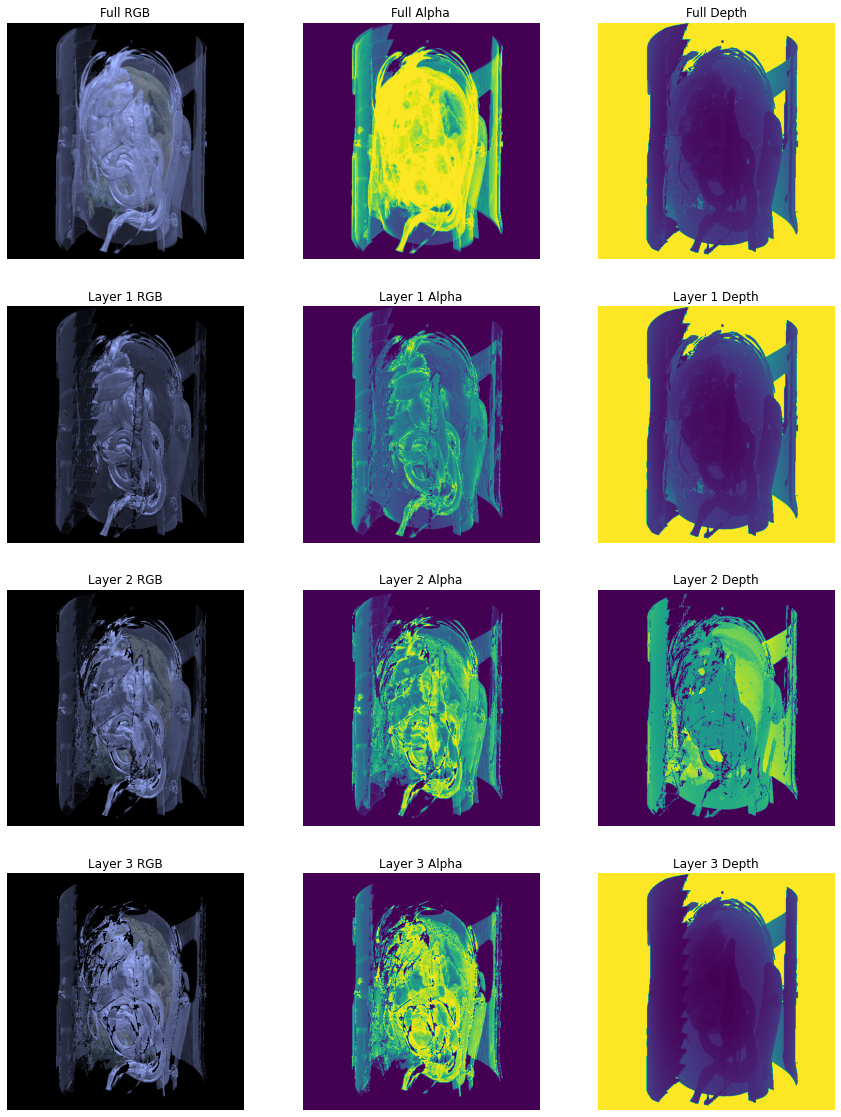

In [44]:
show_all_ims(rgbad.cpu())

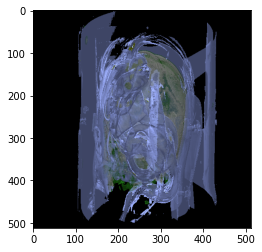

In [45]:
plt.imshow(back[:3].cpu().permute(1,2,0))

In [ ]:
rgbad1 = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.MIDA, layer_dist_thresh=1e-2).squeeze(0)
#rgbad2 = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP).squeeze(0)
print((rgbad[7:10] == rgbad[15:18]).all(), (rgbad[10] == rgbad[18]).all())
show_all_ims(rgbad1.cpu())
#show_all_ims(rgbad2.cpu())

In [ ]:
(raycaster.vr.exit[100,100] - raycaster.vr.entry[100,100]) / raycaster.vr.sample_step_nums[100,100]

In [ ]:
lf = get_rand_pos(1).float().to('cuda')
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')

In [ ]:
full = rgbad1[:4]
layer1 = torch.cat([rgbad1[7:11],  rgbad1[[4]]], dim=0)
layer2 = torch.cat([rgbad1[11:15], rgbad1[[5]]], dim=0)
layer3 = torch.cat([rgbad1[15:19], rgbad1[[6]]], dim=0)
stac = torch.stack([layer1, layer2, layer3])

In [ ]:
val, idx = torch.sort(stac[:, 4], dim=0, stable=True)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(val[0].cpu())
ax[1].imshow(val[1].cpu())
ax[2].imshow(val[2].cpu())
fig.show()

In [ ]:
stac.shape, idx.shape

In [ ]:
idx.shape

In [ ]:
stac[:,0].shape

In [ ]:
sorted_stac = torch.stack([stac[:, i].gather(dim=0, index=idx) for i in range(stac.size(1))], dim=1)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(sorted_stac[0, [4]].permute(1,2,0).cpu())
ax[1].imshow(sorted_stac[1, [4]].permute(1,2,0).cpu())
ax[2].imshow(sorted_stac[2, [4]].permute(1,2,0).cpu())
fig.show()

In [ ]:
a = torch.rand(2, 3, 3)
b = torch.zeros_like(a)
i = torch.argsort(a, dim=0)
a.shape, i.shape

In [ ]:
a_sort, _ = a.sort(dim=0)

In [ ]:
a, i

In [ ]:
a_sort

In [ ]:
a[0][i[0]]

In [ ]:
red[idx].shape

In [ ]:
sortstac = stac.permute(1,0,2,3)[:, idx]

In [ ]:
stac.shape

In [ ]:
sortstac = stac.permute(1,0,2,3).cpu()[:, idx]

In [ ]:
back1 = (full - layer1[4] * layer1[:4]) / (1.0 - layer1[4])

In [ ]:
plt.imshow(back1[[3]].permute(1,2,0).cpu())

In [ ]:
plt.imshow(layer1[:3].permute(1,2,0).cpu())

In [ ]:
lt = 5e-3
rgbad1 = raycaster.raycast_nondiff(vol[None], tf, lf, sampling_rate=SR, mode=Mode.MIDA, 
        layer_dist_thresh=lt).squeeze(0)
rgbad2 = raycaster.raycast_nondiff(vol[None], tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP,            
        layer_dist_thresh=lt).squeeze(0)

show_all_ims(rgbad1.cpu())
show_all_ims(rgbad2.cpu())

In [ ]:
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP).squeeze(0)
show_all_ims(rgbad.cpu())

In [ ]:
tf = tfgen.generate()
while len(tf) == 8: # single peak
    tf = tfgen.generate()
n_peaks = (len(tf)-2)//6
single_peaks = []
for i in range(n_peaks):
    peak = torch.cat([tf[[0]], tf[6*i+1 : 6*(i+1)+1], tf[[-1]]], dim=0)
    single_peaks.append({'pts': peak, 'tex': tex_from_pts(peak, TF_RES)})
    
rgbad_full = raycaster.raycast_nondiff(vol.float().cuda(), tex_from_pts(tf, TF_RES).float().cuda(),
                                       lf.float().cuda(), sampling_rate=SR).squeeze(0).detach().cpu()
#rgbad_full[4:][(rgbad_full[4:] == 0.0)] = 1.0
show_im(rgbad_full)
print((rgbad_full[3] > 0.0).float().mean())

single_peak_renders = []
for p in single_peaks:
    rgbad = raycaster.raycast_nondiff(vol.float().cuda(), p['tex'].float().cuda(), 
                                      lf.float().cuda(), sampling_rate=SR).squeeze(0)
    
    rgbad[4:][(rgbad[4:] == 0.0)] = 1.0
    
    single_peak_renders.append(rgbad.detach().cpu())
    fig, ax = plt.subplot_mosaic([['hist', 'hist', 'tf1'], 
                                  ['hist', 'hist', 'tf2'], 
                                  ['rgb', 'alpha', 'wysiwyp'],
                                  ['depth1', 'depth2', 'depth3'],
                                  ['alpha1', 'alpha2', 'alpha3'],
                                  ['sorted1', 'sorted2', 'sorted3']], figsize=(15,25), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
    })
    show_hist(rgbad[3], ax['hist'], title='Alpha Histogram')
    show_tf(p['pts'], ax=ax['tf1'], title='Current TF Peak')
    show_tf(tf, ax=ax['tf2'], title='Full Transfer Function')
    show_im(rgbad, axs=ax)
    
    fig.show()

for r, p in zip(single_peak_renders, single_peaks):
    abs_diff = torch.abs(r[:4] - rgbad_full[:4])
    abs_ddif = torch.abs(r[[4]] - rgbad_full[[4]])
    mae = abs_diff.mean()
    pct = (abs_diff.max(dim=0).values > 0.1).float().mean().item()
    fig, ax = plt.subplot_mosaic([['single', 'full', 'diff'],
                                  ['sdepth', 'fdepth', 'ddepth'],
                                  ['salpha', 'falpha', 'dalpha'],
                                  ['tf1', 'tf2', 'hist']], figsize=(15,12), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [5.0, 5.0, 5.0, 2.0]
    })
    ax['single'].imshow(r[:3].permute(1,2,0))
    ax['single'].set_title('Partial RGB')
    ax['single'].set_axis_off()
    
    ax['full'].imshow(rgbad_full[:3].permute(1,2,0))
    ax['full'].set_title('Full RGB')
    ax['full'].set_axis_off()
    ax['diff'].imshow(abs_diff[:3].permute(1,2,0))
    ax['diff'].set_title(f'Abs RGB Difference. Pct: {pct:.1%}')
    ax['diff'].set_axis_off()
    
    ax['sdepth'].imshow(r[[4,4,4]].permute(1,2,0))
    ax['sdepth'].set_title('Partial Depth')
    ax['sdepth'].set_axis_off()
    ax['fdepth'].imshow(rgbad_full[[4,4,4]].permute(1,2,0))
    ax['fdepth'].set_title('Full Depth')
    ax['fdepth'].set_axis_off()
    ax['ddepth'].imshow(abs_ddif.permute(1,2,0))
    ax['ddepth'].set_title('Depth Difference')
    ax['ddepth'].set_axis_off()
    show_tf(p['pts'], ax=ax['tf1'], title='Partial TF')
    show_tf(tf, ax=ax['tf2'], title='Full TF')
    show_hist(abs_diff.max(dim=0).values, ax['hist'], title='Difference Histogram', show_percentages=False)
    
    fig.show()
    